# Lesson 1 - Introduction to deep neural networks

In [1]:
%load_ext autoreload
%autoreload 2

## TODO

* Put dataset on the Hub with a loading script
* Figure out how to load `Dataset` objects in dataloaders
* Tidy up, add prose
* Add exercises
* Push model to Hub? => save for next lecture when we actually train from scratch
* Primer on N-subjettiness

## Imports

In [44]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from fastai.tabular.all import *

## Load data

In [3]:
nsubj_dset = load_dataset("lewtun/top_quark_tagging", name="nsubjettiness", split="train")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Using custom data configuration default-39637b94b6989be7


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/lewis/.cache/huggingface/datasets/parquet/default-39637b94b6989be7/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


Generating validation split: 0 examples [00:00, ? examples/s]

Using custom data configuration default-e61835675f94b1e9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/lewis/.cache/huggingface/datasets/parquet/default-e61835675f94b1e9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


Generating test split: 0 examples [00:00, ? examples/s]

Using custom data configuration default-7a2b28b0fd3ee604


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/lewis/.cache/huggingface/datasets/parquet/default-7a2b28b0fd3ee604/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.
Dataset top_quark_tagging downloaded and prepared to /home/lewis/.cache/huggingface/datasets/lewtun___top_quark_tagging/nsubjettiness/0.0.0/6de286bd1d56b73a8bc020b4a5487e37ff3a690841b71c70989a2cb849848f89. Subsequent calls will reuse this data.


In [4]:
nsubj_dset

Dataset({
    features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
    num_rows: 1211000
})

In [5]:
df = nsubj_dset.to_pandas()

In [6]:
df.head()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
0,543.633972,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,0.000011,0.001115,0.000008,0
1,452.411865,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,0.000163,0.005454,0.000072,0
2,429.495270,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,0.001385,0.012678,0.000567,0
3,512.675415,0.102580,0.011369,0.000170,0.086306,0.007759,0.000071,0.068169,0.005386,0.000048,0.002376,0.000008,0
4,527.956848,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,0.004359,0.033249,0.003689,0


In [7]:
df["is_signal_new"].value_counts()

0    605523
1    605477
Name: is_signal_new, dtype: int64

In [23]:
train_df, test_df = train_test_split(df)

In [25]:
train_df.shape

(908250, 13)

In [26]:
test_df.shape

(302750, 13)

In [27]:
sample_df = train_df.sample(n=100_000, random_state=42)

In [28]:
sample_df["is_signal_new"].value_counts()

1    50185
0    49815
Name: is_signal_new, dtype: int64

## Create data loaders

In [29]:
features = sample_df.columns.drop("is_signal_new")

In [30]:
splits = RandomSplitter(valid_pct=0.10)(range_of(df[:85_000]))

In [31]:
splits

((#76500) [34813,14564,65209,49472,69128,46709,57207,73510,15847,32026...],
 (#8500) [63739,65314,21683,28284,22165,52995,27209,23541,1850,78596...])

In [32]:
dls = TabularDataLoaders.from_df(sample_df, y_names="is_signal_new", bs=1000, y_block=CategoryBlock, splits=splits)

In [33]:
dls.show_batch()

,tau_4_2,tau_1_0.5,tau_2_0.5,tau_2_2,tau_2_1,tau_3_2,tau_1_1,tau_1_2,tau_4_1,tau_4_0.5,tau_3_1,tau_3_0.5,is_signal_new
0,0.002777,441.215393,0.074535,0.086947,0.276038,0.044386,0.528368,0.272553,0.030299,0.003536,0.202745,0.013085,1
1,0.000132,576.360718,0.000601,0.010034,0.078334,0.008359,0.130199,0.019437,0.006016,0.000215,0.070089,0.000278,0
2,0.005199,384.253113,0.084608,0.126435,0.354513,0.088373,0.532427,0.281507,0.061778,0.010225,0.280693,0.016943,1
3,0.001447,509.842529,0.049615,0.106640,0.295423,0.033763,0.402925,0.174615,0.026291,0.002476,0.163897,0.025785,1
4,0.001487,416.946899,0.041824,0.065809,0.225147,0.040160,0.334466,0.138401,0.027568,0.006057,0.160053,0.010943,1
5,0.000975,479.938293,0.069743,0.071532,0.248328,0.032414,0.508649,0.258250,0.020523,0.001858,0.164908,0.011656,1
6,0.004175,504.706848,0.027598,0.062499,0.235053,0.044049,0.298077,0.111748,0.028002,0.005130,0.187525,0.007169,0
7,0.000714,527.025635,0.012327,0.048450,0.216248,0.019981,0.257796,0.078500,0.012484,0.000992,0.111528,0.002733,0
8,0.007010,469.466553,0.153218,0.125269,0.344477,0.083169,0.632687,0.386468,0.047925,0.013177,0.263503,0.026248,1
9,0.001172,466.757050,0.053230,0.050794,0.209271,0.032802,0.339307,0.146132,0.020747,0.002579,0.166957,0.004821,1


In [34]:
learn = tabular_learner(dls, layers=[100,100], metrics=[accuracy, RocAucBinary()])

In [35]:
learn.summary()

TabularModel (Input shape: 1000 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1000 x 12           
BatchNorm1d                               24         True      
____________________________________________________________________________
                     1000 x 100          
Linear                                    1200       True      
ReLU                                                           
BatchNorm1d                               200        True      
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     1000 x 2            
Linear                                    202        True      
____________________________________________________________________________

Total params: 11,826
Total tr

SuggestedLRs(valley=0.0014454397605732083)

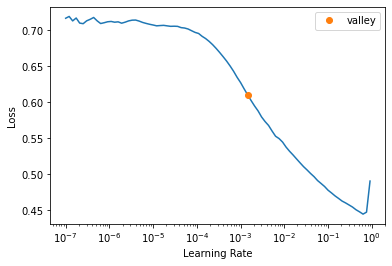

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.355766,0.293832,0.872400,0.944473,00:00
1,0.302097,0.280379,0.877150,0.950258,00:00
2,0.285595,0.277358,0.877750,0.951282,00:00


In [38]:
learn.show_results()

,tau_4_2,tau_1_0.5,tau_2_0.5,tau_2_2,tau_2_1,tau_3_2,tau_1_1,tau_1_2,tau_4_1,tau_4_0.5,tau_3_1,tau_3_0.5,is_signal_new,is_signal_new_pred
0,0.000000,540.477051,0.000302,0.001867,0.027803,0.000659,0.075491,0.007854,0.000000,0.000008,0.019679,0.000034,0.0,0.0
1,0.003022,496.872711,4.480433,0.072395,0.241002,0.046703,0.714757,0.942276,0.037865,0.003976,0.198403,0.009224,0.0,1.0
2,0.000003,519.949341,0.000024,0.002448,0.044243,0.001114,0.040280,0.002792,0.000861,0.000004,0.027938,0.000015,0.0,0.0
3,0.002650,464.712891,0.086075,0.116142,0.332644,0.036104,0.535061,0.283257,0.031346,0.002866,0.178635,0.017234,1.0,1.0
4,0.000022,525.882263,0.000254,0.006961,0.070747,0.004679,0.082872,0.009469,0.002600,0.000090,0.055170,0.000138,0.0,0.0
5,0.000189,531.225220,0.002503,0.021948,0.132333,0.012336,0.165050,0.033305,0.005691,0.000444,0.094771,0.001425,0.0,0.0
6,0.000002,535.681519,0.004411,0.008653,0.077265,0.004027,0.242011,0.061206,0.000767,0.000036,0.043582,0.000111,0.0,0.0
7,0.001891,468.946167,0.010646,0.065812,0.250716,0.054828,0.289389,0.089976,0.035511,0.003939,0.226285,0.005331,0.0,0.0
8,0.001709,472.518616,0.075037,0.125395,0.333533,0.031601,0.428955,0.217078,0.024324,0.002482,0.150076,0.024317,1.0,1.0


In [39]:
test_dl = learn.dls.test_dl(test_df)

In [40]:
preds = learn.get_preds(dl=test_dl)

In [41]:
preds

(tensor([[0.0976, 0.9024],
         [0.0847, 0.9153],
         [0.3953, 0.6047],
         ...,
         [0.4001, 0.5999],
         [0.9862, 0.0138],
         [0.0725, 0.9275]]),
 tensor([[1],
         [0],
         [1],
         ...,
         [0],
         [0],
         [1]], dtype=torch.int8))

In [42]:
preds[0]

tensor([[0.0976, 0.9024],
        [0.0847, 0.9153],
        [0.3953, 0.6047],
        ...,
        [0.4001, 0.5999],
        [0.9862, 0.0138],
        [0.0725, 0.9275]])

In [45]:
rc = roc_curve(test_df["is_signal_new"], preds[0][:, 1])

In [46]:
len(rc)

3

In [47]:
rc[0].shape

(61321,)

In [48]:
rc[1].shape

(61321,)

In [49]:
rc[2].shape

(61321,)

(0.0, 1.0)

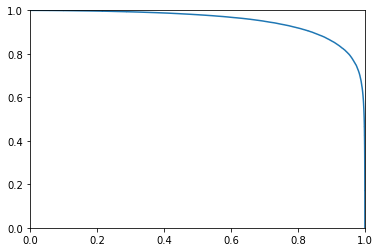

In [50]:
plt.plot(rc[1], 1-rc[0], '-')
plt.xlim(0, 1)
plt.ylim(0, 1)

## Try with Tabular model

In [53]:
nsubs=12
model = nn.Sequential(nn.Linear(nsubs, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 2))

In [54]:
model.eval()

Sequential(
  (0): Linear(in_features=12, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)

In [70]:
torch.from_numpy(np.array(inputs))

tensor([4.8312e+02, 3.0377e-01, 1.2350e-01, 4.4046e-02, 2.5815e-01, 8.4568e-02,
        2.5386e-02, 1.6574e-01, 3.2938e-02, 1.7562e-03, 2.4802e-02, 1.2312e-03,
        1.0000e+00], dtype=torch.float64)

In [73]:
inputs

tensor([4.8312e+02, 3.0377e-01, 1.2350e-01, 4.4046e-02, 2.5815e-01, 8.4568e-02,
        2.5386e-02, 1.6574e-01, 3.2938e-02, 1.7562e-03, 2.4802e-02, 1.2312e-03],
       dtype=torch.float64)

In [74]:
inputs = train_df.iloc[0, :-1]
inputs = torch.from_numpy(np.array(inputs)).float()
model.forward(inputs)

tensor([-18.8246,  -4.6523], grad_fn=<AddBackward0>)

In [80]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=12, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [82]:
learn.model.n_cont

12

In [90]:
emb_szs = []
m = TabularModel(emb_szs, n_cont=12, out_sz=2, layers=[100,100]).eval()

In [98]:
inputs.shape

torch.Size([12])

In [101]:
inputs.dim()

1

In [89]:
tab_learn = TabularLearner(dls, m, metrics=[accuracy, RocAucBinary()])

SuggestedLRs(valley=0.0012022644514217973)

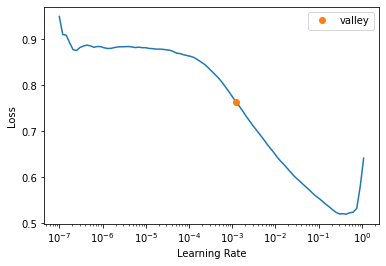

In [93]:
tab_learn.lr_find()

In [94]:
tab_learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.388897,0.293609,0.872350,0.944520,00:00
1,0.307618,0.281418,0.877400,0.949350,00:00
2,0.289134,0.279580,0.878250,0.949996,00:00


## Down to here

## Imports

In [ ]:
import numpy as np
import pandas as pd
from datasets import Dataset
from pytorch_lightning import LightningModule, Trainer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchmetrics
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from huggingface_hub import PyTorchModelHubMixin

## Load data

In [ ]:
EVENTS_PATH = "data/QG_nsubs.npz?dl=1"

with np.load(EVENTS_PATH) as f:
    X, y = f['X'], f['y']

In [ ]:
X.shape, y.shape

((100000, 45), (100000,))

In [ ]:
data = {f"feature_{idx}":X[:, idx] for idx in range(45)}

In [ ]:
data["label"] = y

In [ ]:
df = pd.DataFrame(data)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,label
0,0.582885,0.359834,0.159466,0.286434,0.109313,0.031360,0.291994,0.104627,0.025298,0.269625,...,0.191827,0.045562,0.004745,0.183424,0.042593,0.004490,0.174668,0.039015,0.004060,0.0
1,0.260756,0.084642,0.019812,0.240676,0.073122,0.015786,0.225725,0.063897,0.012387,0.215447,...,0.126111,0.021134,0.002316,0.122458,0.018581,0.001079,0.117416,0.017345,0.000992,0.0
2,0.564012,0.330684,0.127177,0.292710,0.110119,0.024787,0.258846,0.086578,0.017215,0.240176,...,0.150572,0.034919,0.003328,0.147431,0.032971,0.003017,0.143079,0.031147,0.002829,0.0
3,0.395935,0.170801,0.042085,0.344588,0.130606,0.026208,0.271026,0.090233,0.017891,0.243731,...,0.164546,0.034850,0.004036,0.151774,0.029703,0.002897,0.149630,0.028986,0.002850,0.0
4,0.196304,0.051556,0.011701,0.192528,0.048644,0.010743,0.178389,0.043404,0.009060,0.172218,...,0.084400,0.012952,0.001005,0.078391,0.011012,0.000815,0.076849,0.010029,0.000572,0.0


In [ ]:
# Can't use categorical
dset = Dataset.from_pandas(df)
dset

Dataset({
    features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'label'],
    num_rows: 100000
})

In [ ]:
X.shape

(100000, 45)

In [ ]:
y.shape

(100000,)

In [ ]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [ ]:
num_nsubs = 1
X = X[:, :num_nsubs]

In [ ]:
X_train, X_val, X_test = X[:75_000], X[75_000:85_000], X[85_000:]
y_train, y_val, y_test = y[:75_000], y[75_000:85_000], y[85_000:]

In [ ]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=100)
test_dl = DataLoader(test_ds, batch_size=100)

## Define model

In [ ]:
class DNNModel(LightningModule):
    def __init__(self, nsubs = 45):
        super().__init__()
        self.nsubs = nsubs
        self.accuracy = torchmetrics.Accuracy()
        self.roc_auc = torchmetrics.AUROC(num_classes=2)
        self.layers = nn.Sequential(nn.Linear(self.nsubs, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 2))

    def forward(self, batch):
        x, y = batch
        x = self.layers(x.view(x.size(0), -1))
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.roc_auc(y_hat, y)
        self.log("val_accuracy", self.accuracy, on_epoch=True, prog_bar=True)
        self.log("val_roc_auc", self.roc_auc, on_epoch=True, )
        self.log("val_loss", val_loss, on_epoch=True,)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.roc_auc(y_hat, y)
        self.log("test_accuracy", self.accuracy, on_epoch=True, prog_bar=True)
        self.log("test_roc_auc", self.roc_auc, on_epoch=True, )
        self.log("test_loss", val_loss, on_epoch=True,)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    def train_dataloader(self):
        return train_dl

    def val_dataloader(self):
        return valid_dl

    def test_dataloader(self):
        return test_dl

In [ ]:
batch = next(iter(test_dl))

In [ ]:
model = DNNModel(nsubs=1)

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
model(batch).shape

torch.Size([100, 2])

In [ ]:
model.summarize()

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary.py:471: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=1` to replicate `mode=top` behavior.
  rank_zero_deprecation(


  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | roc_auc  | AUROC      | 0     
2 | layers   | Sequential | 10.5 K
----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)

In [ ]:
trainer = Trainer(
    gpus=1,
    max_epochs=10,
    # auto_lr_find=True
    # progress_bar_refresh_rate=100,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | roc_auc  | AUROC      | 0     
2 | layers   | Sequential | 10.5 K
----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6751999855041504,
 'test_loss': 0.5903524160385132,
 'test_roc_auc': 0.7281567454338074}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.6751999855041504,
  'test_roc_auc': 0.7281567454338074,
  'test_loss': 0.5903524160385132}]

In [ ]:
preds = trainer.predict(model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
len(preds)

150

In [ ]:
preds_np = np.vstack(preds)

In [ ]:
preds_np.shape

(15000, 2)

In [ ]:
y_test.numpy().shape

(15000,)

In [ ]:
preds[0][0]

tensor([-0.5266, -0.8931])

In [ ]:
roc_auc_score(y_test, preds_np[:, 1])

0.7281606545078303

In [ ]:
rc = roc_curve(y_test, preds_np[:, 1])

In [ ]:
len(rc)

3

In [ ]:
rc[0].shape

(6252,)

In [ ]:
rc[1].shape

(6252,)

In [ ]:
rc[2].shape

(6252,)

(0.0, 1.0)

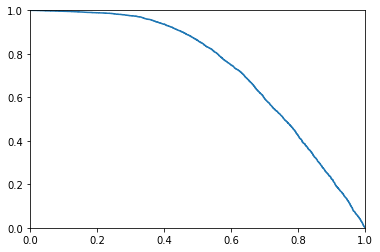

In [ ]:
plt.plot(rc[1], 1-rc[0], '-')
plt.xlim(0, 1)
plt.ylim(0, 1)

## With fastai

In [ ]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,label
0,0.582885,0.359834,0.159466,0.286434,0.109313,0.031360,0.291994,0.104627,0.025298,0.269625,...,0.191827,0.045562,0.004745,0.183424,0.042593,0.004490,0.174668,0.039015,0.004060,0.0
1,0.260756,0.084642,0.019812,0.240676,0.073122,0.015786,0.225725,0.063897,0.012387,0.215447,...,0.126111,0.021134,0.002316,0.122458,0.018581,0.001079,0.117416,0.017345,0.000992,0.0
2,0.564012,0.330684,0.127177,0.292710,0.110119,0.024787,0.258846,0.086578,0.017215,0.240176,...,0.150572,0.034919,0.003328,0.147431,0.032971,0.003017,0.143079,0.031147,0.002829,0.0
3,0.395935,0.170801,0.042085,0.344588,0.130606,0.026208,0.271026,0.090233,0.017891,0.243731,...,0.164546,0.034850,0.004036,0.151774,0.029703,0.002897,0.149630,0.028986,0.002850,0.0
4,0.196304,0.051556,0.011701,0.192528,0.048644,0.010743,0.178389,0.043404,0.009060,0.172218,...,0.084400,0.012952,0.001005,0.078391,0.011012,0.000815,0.076849,0.010029,0.000572,0.0


In [ ]:
df["label"].nunique()

2

In [ ]:
from fastai.tabular.all import *